### Erddap Quicklooks of ThingSpeak archived data

__pyversion__==3.7   
__author__==S.Bell

__Notes:__ 

```
Full Scale details... temp better at 25degC

DHT11 - 0-50C +/- 2degC, 0.1
      - 20-90% +/- 5%, 1
      
BMP180 - temp is +/- 2degc
       - baro is +/- 1hpa (and a 1hpa res for relative?)
       
--

Office Station - SParkFun redboard with BME280 T/RH/P
               - UV Sensor (VEML6075)
               
               - 20-80% RH is +/- 3%
               - baro is +/- 1hpa
               - temp is +/- 0.5degc
```

In [140]:
import datetime
print("Last run {0}".format(datetime.datetime.now()))

Last run 2019-11-21 08:20:28.795688


In [141]:
stations = ['channel_843357_thingspeak','OfficeRedboard_WxStation']
station_accuracy = {stations[0]: {'Temp':2,'Baro':1,'RH':5},stations[1]: {'Temp':0.5,'Baro':1,'RH':3}}

In [142]:
from erddapy import ERDDAP
import pandas as pd
import numpy as np

server_url = 'http://downdraft.pmel.noaa.gov:8080/erddap'

e = ERDDAP(server=server_url)

variables = [e.get_var_by_attr(dataset_id=prawler, standard_name=lambda v: v is not None) for prawler in stations]
print(variables)

[['SLP', 'BaroTemp', 'Temp', 'time', 'RH_Percent'], ['UVB', 'Altitude', 'SLP', 'Temp', 'time', 'UVA', 'RH_Percent', 'UVindex']]


In [143]:
df_stations= {}

for ind, station in enumerate(stations):
    d = ERDDAP(server=server_url,
               protocol='tabledap',
               response='csv',
              )

    d.dataset_id=station
    
    d.variables =  [d.get_var_by_attr(dataset_id=prawler, standard_name=lambda v: v is not None) for prawler in [d.dataset_id]][0]

    d.constraints = {
        'time>=': datetime.datetime.utcnow()-datetime.timedelta(days=30),
        'time<=': datetime.datetime.utcnow()
    }

    print(d.get_download_url())

    df = d.to_pandas(
        index_col='time (UTC)',
        parse_dates=True,
        skiprows=(1,)  # units information can be dropped.
    ).dropna()

    df.sort_index(inplace=True)
    df.columns = [x[1].split()[0] for x in enumerate(df.columns)]

    if df['SLP'].mean() > 90000:
        df[df['SLP'] > 110000] = np.nan
    else:
        df[df['SLP'] > 1100] = np.nan
    df.tail()
    
    df_stations.update({station: df})

http://downdraft.pmel.noaa.gov:8080/erddap/tabledap/channel_843357_thingspeak.csv?SLP,BaroTemp,Temp,time,RH_Percent&time>=1571761228.907381&time<=1574353228.907389
http://downdraft.pmel.noaa.gov:8080/erddap/tabledap/OfficeRedboard_WxStation.csv?UVB,Altitude,SLP,Temp,time,UVA,RH_Percent,UVindex&time>=1571761236.285658&time<=1574353236.285665


In [144]:
datetime.datetime.utcnow()

datetime.datetime(2019, 11, 21, 16, 20, 40, 823682)

In [145]:
#get some nearby data
import requests
import xml.etree.ElementTree as ET

user_agent_url = 'https://w1.weather.gov/xml/current_obs/KPAE.xml'
kpae = {} #Payne Field
try:
    xml_data = requests.get(user_agent_url).content
    res = requests.get("http://w1.weather.gov/xml/current_obs/KPAE.xml")
    xml_tree = ET.fromstring(res.text)
    kpae['temp_c'] = xml_tree.find('temp_c').text
    kpae['relative_humidity'] = xml_tree.find('relative_humidity').text
    kpae['pressure_mb'] = xml_tree.find('pressure_mb').text
    kpae['observation_time_rfc822'] = xml_tree.find('observation_time_rfc822').text
    kpae['datetime'] = datetime.datetime.strptime(kpae['observation_time_rfc822'],'%a, %d %b %Y %H:%M:%S %z')
except:
    pass

kpae

{'temp_c': '1.7',
 'relative_humidity': '93',
 'pressure_mb': '1016.0',
 'observation_time_rfc822': 'Thu, 21 Nov 2019 07:53:00 -0800',
 'datetime': datetime.datetime(2019, 11, 21, 7, 53, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=57600)))}

In [146]:
kpae['observation_time_rfc822'] = xml_tree.find('observation_time_rfc822').text

In [147]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter
import matplotlib.ticker as ticker

import cmocean
### specify primary bulk figure parameters
fontsize = 10
labelsize = 10
#plotstyle = 'seaborn'
max_xticks = 10
plt.style.use('seaborn-ticks')
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['ps.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['pdf.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.edgecolor'] = 'black'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.labelcolor'] = 'black'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['xtick.major.size'] = 4
mpl.rcParams['xtick.minor.size'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.width'] = 0.5
mpl.rcParams['ytick.major.size'] = 4
mpl.rcParams['ytick.minor.size'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.width'] = 0.5
mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['xtick.color'] = 'black'

Average difference between two sensors for all time: -0.5178835063436299
Average difference between two sensors for last two weeks: -0.5296807071084859
Average difference between two sensors for last two days: -0.6739921976593665


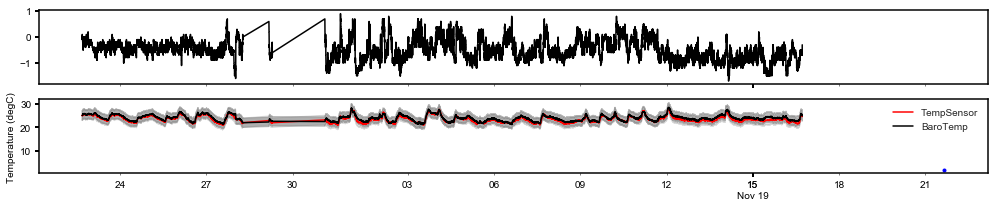

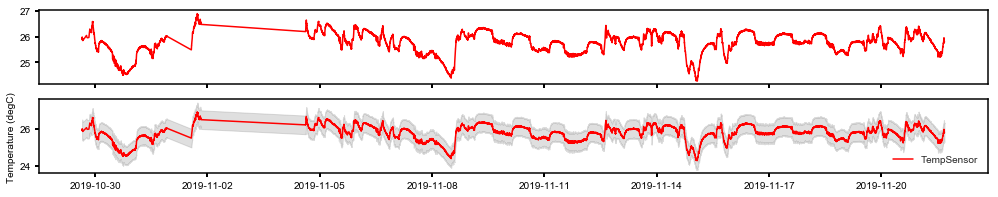

In [148]:
for i,dft in enumerate(df_stations):
    df=df_stations[dft]
    fig, (ax2, ax1) = plt.subplots(2,1,sharex='col',figsize=(17,3))
    try:
        df['BaroTemp']
        ax1.plot(df.index,df['Temp'],'r',df.index,df['BaroTemp'],'k')
        ax1.fill_between(df.index,df['Temp']-station_accuracy[dft]['Temp'],df['Temp']+station_accuracy[dft]['Temp'],color='grey',alpha=.25)
        ax1.fill_between(df.index,df['BaroTemp']-station_accuracy[dft]['Temp'],df['BaroTemp']+station_accuracy[dft]['Temp'],color='grey',alpha=.5)
        ax2.plot(df.index,df['Temp']-df['BaroTemp'],'k')
        plt.ylabel('Temperature (degC)')
        plt.legend(['TempSensor','BaroTemp'])
        local_station=True

        #ax1.set_xlim(df.index[0], df.index[-1])
        xfmt = mdates.DateFormatter('%d-%b')
        ax1.xaxis.set_major_locator(DayLocator(bymonthday=15))
        ax1.xaxis.set_minor_locator(DayLocator(range(0,32,3)))
        ax1.xaxis.set_minor_formatter(DateFormatter('%d'))
        ax1.xaxis.set_major_formatter(DateFormatter('%d\n%b %y'))
        ax1.xaxis.set_tick_params(which='major', pad=3)
        ax1.xaxis.set_tick_params(which='minor', pad=5)

        print(f"Average difference between two sensors for all time: {(df['Temp']-df['BaroTemp']).mean()}")
        two_weeks_delta = (df['Temp'][df.last_valid_index()-pd.DateOffset(14, 'D'):] - 
                          df['BaroTemp'][df.last_valid_index()-pd.DateOffset(14, 'D'):]).mean()
        print(f"Average difference between two sensors for last two weeks: {two_weeks_delta}")
        two_days_delta = (df['Temp'][df.last_valid_index()-pd.DateOffset(2, 'D'):] - 
                          df['BaroTemp'][df.last_valid_index()-pd.DateOffset(2, 'D'):]).mean()
        print(f"Average difference between two sensors for last two days: {two_days_delta}")        
    except:
        ax1.plot(df.index,df['Temp'],'r',)
        ax1.fill_between(df.index,df['Temp']-station_accuracy[dft]['Temp'],df['Temp']+station_accuracy[dft]['Temp'],color='grey',alpha=.25)
        ax2.plot(df.index,df['Temp'],'r')
        plt.ylabel('Temperature (degC)')
        plt.legend(['TempSensor'])
        local_station=False

    try:
        pass
        if local_station:
            ax1.plot(kpae['datetime'],np.float(kpae['temp_c']),'ob',markersize=3)
    except:
        pass
    



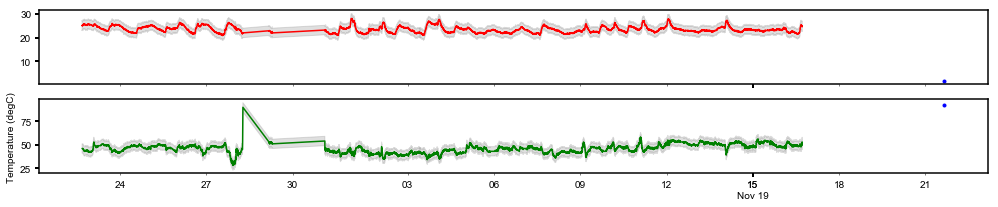

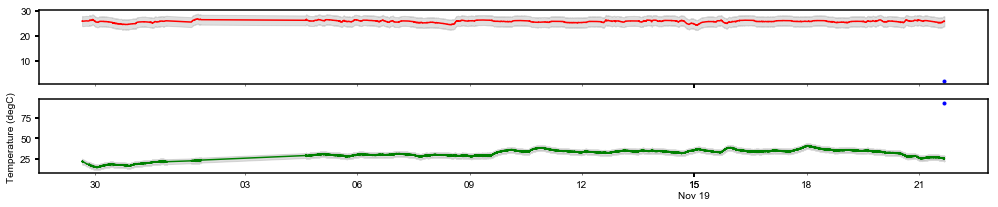

In [149]:
for i,dft in enumerate(df_stations):
    df=df_stations[dft]
    fig, (ax2, ax1) = plt.subplots(2,1,sharex='col',figsize=(17,3))
    ax1.plot(df.index,df['RH_Percent'],'g')
    ax1.fill_between(df.index,df['RH_Percent']-station_accuracy[dft]['RH'],df['RH_Percent']+station_accuracy[dft]['RH'],color='grey',alpha=.25)
    ax2.plot(df.index,df['Temp'],'r')
    ax2.fill_between(df.index,df['Temp']-2,df['Temp']+2,color='grey',alpha=.25)
    plt.ylabel('Temperature (degC)')

    try:
        pass
        ax1.plot(kpae['datetime'],np.float(kpae['relative_humidity']),'ob',markersize=3)
        ax2.plot(kpae['datetime'],np.float(kpae['temp_c']),'ob',markersize=3)
    except:
        pass

    xfmt = mdates.DateFormatter('%d-%b')
    ax1.xaxis.set_major_locator(DayLocator(bymonthday=15))
    ax1.xaxis.set_minor_locator(DayLocator(range(0,32,3)))
    ax1.xaxis.set_minor_formatter(DateFormatter('%d'))
    ax1.xaxis.set_major_formatter(DateFormatter('%d\n%b %y'))
    ax1.xaxis.set_tick_params(which='major', pad=3)
    ax1.xaxis.set_tick_params(which='minor', pad=5)
    #ax1.set_xlim([datetime.datetime.utcnow()-datetime.timedelta(days=30),datetime.datetime.utcnow()])

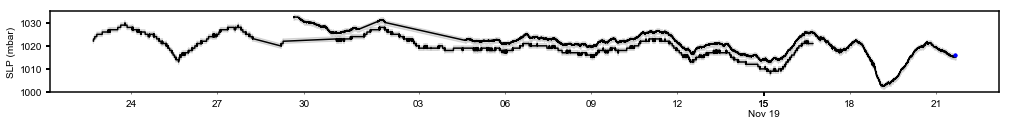

In [150]:
fig, ax1 = plt.subplots(1,1,sharex='col',figsize=(17,1.5))
for i,dft in enumerate(df_stations):
    df=df_stations[dft]
    if df['SLP'].mean() >10000:
        ax1.plot(df.index,df['SLP']/100,'k')
        ax1.fill_between(df.index,df['SLP']/100-station_accuracy[dft]['Baro'],
                         df['SLP']/100+station_accuracy[dft]['Baro'],color='grey',alpha=.25)
    else:
        ax1.plot(df.index,df['SLP'],'k')
        ax1.fill_between(df.index,df['SLP']-station_accuracy[dft]['Baro'],df['SLP']+station_accuracy[dft]['Baro'],color='grey',alpha=.25)
    plt.ylabel('SLP (mbar)')

    try:
        pass
        ax1.plot(kpae['datetime'],np.float(kpae['pressure_mb']),'ob',markersize=3)
    except:
        pass

    xfmt = mdates.DateFormatter('%d-%b')
    ax1.xaxis.set_major_locator(DayLocator(bymonthday=15))
    ax1.xaxis.set_minor_locator(DayLocator(range(0,32,3)))
    ax1.xaxis.set_minor_formatter(DateFormatter('%d'))
    ax1.xaxis.set_major_formatter(DateFormatter('%d\n%b %y'))
    ax1.xaxis.set_tick_params(which='major', pad=3)
    ax1.xaxis.set_tick_params(which='minor', pad=5)

In [151]:
df = df_stations['channel_843357_thingspeak']
df = df_stations['OfficeRedboard_WxStation']
### build a table of daily max/min
daily_summary = pd.DataFrame(columns=df.columns)

for column in daily_summary:
    daily_summary[column+' (min)'] = df[column].resample('D').min()
    daily_summary[column+' (max)'] = df[column].resample('D').max()
    daily_summary[column+' (median)'] = df[column].resample('D').median()
    daily_summary[column] = df[column].resample('D').mean()
    
#TODO: export to HTML DataTable

In [152]:
def highlight_max(s):
    '''
    highlight the maximum in a Series red.
    '''
    is_max = s == s.max()
    return ['color: red' if v else '' for v in is_max]

def highlight_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_min = s == s.min()
    return ['color: blue' if v else '' for v in is_min]



In [153]:
daily_summary.style.apply(highlight_max).apply(highlight_min).format("{:.2f}")

,UVB,Altitude,SLP,Temp,UVA,RH_Percent,UVindex,UVB (min),UVB (max),UVB (median),Altitude (min),Altitude (max),Altitude (median),SLP (min),SLP (max),SLP (median),Temp (min),Temp (max),Temp (median),UVA (min),UVA (max),UVA (median),RH_Percent (min),RH_Percent (max),RH_Percent (median),UVindex (min),UVindex (max),UVindex (median)
time (UTC),,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-10-29 00:00:00+00:00,0.00,-495.30,103151.79,26.19,0.00,17.27,0.00,0.00,0.00,0.00,-523.70,-471.30,-497.05,103063.00,103257.00,103158.00,25.77,26.59,26.21,0.00,0.00,0.00,15.00,22.30,17.00,0.00,0.00,0.00
2019-10-30 00:00:00+00:00,0.00,-420.83,102875.49,25.17,0.00,17.19,0.00,0.00,0.00,0.00,-472.60,-332.40,-426.60,102548.00,103068.00,102897.00,24.51,25.85,25.13,0.00,0.00,0.00,14.60,19.00,17.40,0.00,0.00,0.00
2019-10-31 00:00:00+00:00,0.31,-358.83,102645.87,25.54,0.11,20.36,0.00,0.00,15.00,0.00,-396.10,-331.90,-357.20,102546.00,102784.00,102640.00,24.82,26.04,25.59,0.00,6.00,0.00,17.60,22.60,20.30,0.00,0.01,0.00
2019-11-01 00:00:00+00:00,0.00,-478.86,103090.72,26.45,0.00,22.98,0.00,0.00,0.00,0.00,-488.40,-457.80,-481.70,103013.00,103126.00,103101.00,25.49,26.90,26.51,0.00,0.00,0.00,22.30,23.80,23.00,0.00,0.00,0.00
2019-11-02 00:00:00+00:00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2019-11-03 00:00:00+00:00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2019-11-04 00:00:00+00:00,0.00,-251.27,102248.46,26.18,0.00,29.51,0.00,0.00,0.00,0.00,-265.60,-232.70,-252.85,102180.00,102301.00,102254.00,25.89,26.65,26.20,0.00,0.00,0.00,28.30,30.60,29.50,0.00,0.00,0.00
2019-11-05 00:00:00+00:00,0.35,-238.66,102201.93,26.09,0.13,29.46,0.00,0.00,15.00,0.00,-260.10,-203.40,-242.00,102072.00,102281.00,102214.00,25.49,26.52,26.13,0.00,6.00,0.00,27.60,31.20,29.50,0.00,0.01,0.00
2019-11-06 00:00:00+00:00,0.00,-262.11,102288.47,26.01,0.00,30.09,0.00,0.00,0.00,0.00,-325.70,-207.70,-264.20,102088.00,102523.00,102296.00,25.41,26.43,26.04,0.00,0.00,0.00,29.10,31.10,30.10,0.00,0.00,0.00


In [154]:
(daily_summary - daily_summary.mean()).style.bar(align='mid', color=['#d65f5f', '#5fba7d'])


,UVB,Altitude,SLP,Temp,UVA,RH_Percent,UVindex,UVB (min),UVB (max),UVB (median),Altitude (min),Altitude (max),Altitude (median),SLP (min),SLP (max),SLP (median),Temp (min),Temp (max),Temp (median),UVA (min),UVA (max),UVA (median),RH_Percent (min),RH_Percent (max),RH_Percent (median),UVindex (min),UVindex (max),UVindex (median)
time (UTC),,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-10-29 00:00:00+00:00,-0.222795,-272.737,1007.89,0.374968,-0.0802793,-12.8747,-0.000160508,0,-6.09091,0,-240.686,-324.886,-271.348,1198.95,890.727,1002.61,0.543182,0.285909,0.387955,0,-2.36364,0,-13.1227,-10.3091,-13.0364,0,-0.00409091,0
2019-10-30 00:00:00+00:00,-0.222795,-198.265,731.578,-0.638984,-0.0802793,-12.9544,-0.000160508,0,-6.09091,0,-189.586,-185.986,-200.898,683.955,701.727,741.614,-0.716818,-0.454091,-0.692045,0,-2.36364,0,-13.5227,-13.6091,-12.6364,0,-0.00409091,0
2019-10-31 00:00:00+00:00,0.0893744,-136.265,501.959,-0.269414,0.0323435,-9.78657,6.62492e-05,0,8.90909,0,-113.086,-185.486,-131.498,681.955,417.727,484.614,-0.406818,-0.264091,-0.232045,0,3.63636,0,-10.5227,-10.0091,-9.73636,0,0.00590909,0
2019-11-01 00:00:00+00:00,-0.222795,-256.296,946.813,0.63975,-0.0802793,-7.1629,-0.000160508,0,-6.09091,0,-205.386,-311.386,-255.998,1148.95,759.727,945.614,0.263182,0.595909,0.687955,0,-2.36364,0,-5.82273,-8.80909,-7.03636,0,-0.00409091,0
2019-11-02 00:00:00+00:00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2019-11-03 00:00:00+00:00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2019-11-04 00:00:00+00:00,-0.222795,-28.7061,104.549,0.371324,-0.0802793,-0.631318,-0.000160508,0,-6.09091,0,17.4136,-86.2864,-27.1477,315.955,-65.2727,98.6136,0.663182,0.345909,0.377955,0,-2.36364,0,0.177273,-2.00909,-0.536364,0,-0.00409091,0
2019-11-05 00:00:00+00:00,0.123012,-16.0958,58.0224,0.282493,0.0451538,-0.686049,7.5112e-05,0,8.90909,0,22.9136,-56.9864,-16.2977,207.955,-85.2727,58.6136,0.263182,0.215909,0.307955,0,3.63636,0,-0.522727,-1.40909,-0.536364,0,0.00590909,0
2019-11-06 00:00:00+00:00,-0.222795,-39.5405,144.562,0.193366,-0.0802793,-0.0552104,-0.000160508,0,-6.09091,0,-42.6864,-61.2864,-38.4977,223.955,156.727,140.614,0.183182,0.125909,0.217955,0,-2.36364,0,0.977273,-1.50909,0.0636364,0,-0.00409091,0
